In [310]:
# read csv file and clean the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

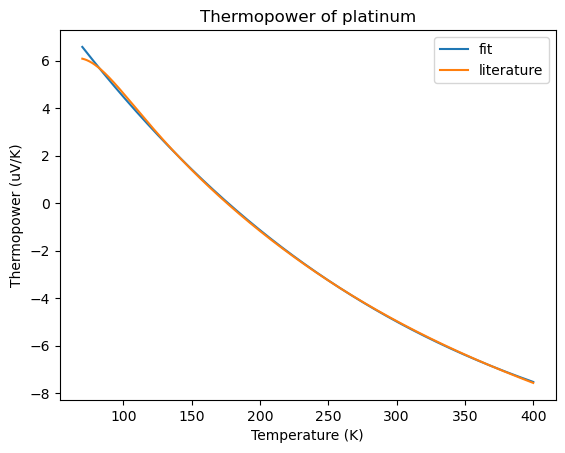

In [509]:
# literature values
# thermopower of platinum

# plot the literature values
plt.figure()
T = np.linspace(70, 400, 1000)
S_Pt = 0.186 * T * (np.exp(-(T/88)) - 0.0786 + (0.43 / (1 + (T / 84.3) ** 4))) - 2.57

# fit S_Pt using a third order polynomial
# fit the data
p = np.polyfit(T, S_Pt, 3)
S_Pt_fit = np.polyval(p, T)

plt.plot(T, S_Pt_fit, label='fit')
plt.plot(T, S_Pt, label='literature')
plt.xlabel('Temperature (K)')
plt.ylabel('Thermopower (uV/K)')
plt.title('Thermopower of platinum')
plt.legend()
plt.show()

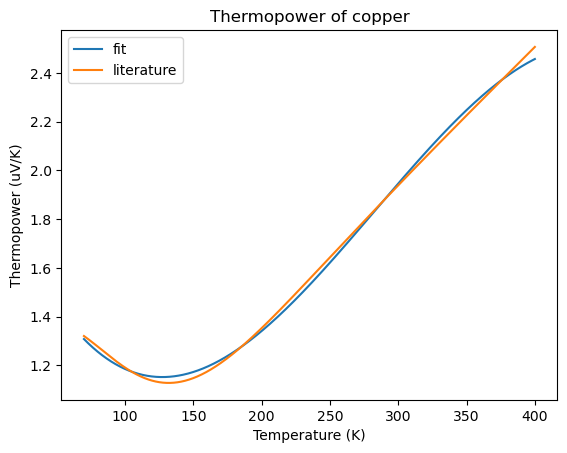

In [510]:
# literature values
# thermopower of copper

# plot the literature values
plt.figure()
T = np.linspace(70, 400, 1000)
S_Cu = 0.041 * T * (np.exp(-T/93) + 0.123 - (0.442)/(1 + (T / 172.4)**3)) + 0.804

# fit S_Cu using a third order polynomial
# fit the data
S_Cu_poly = np.polyfit(T, S_Cu, 3)
S_Cu_fit = np.polyval(S_Cu_poly, T)

plt.plot(T, S_Cu_fit, label='fit')
plt.plot(T, S_Cu, label='literature')
plt.xlabel('Temperature (K)')
plt.ylabel('Thermopower (uV/K)')
plt.title('Thermopower of copper')
plt.legend()
plt.show()

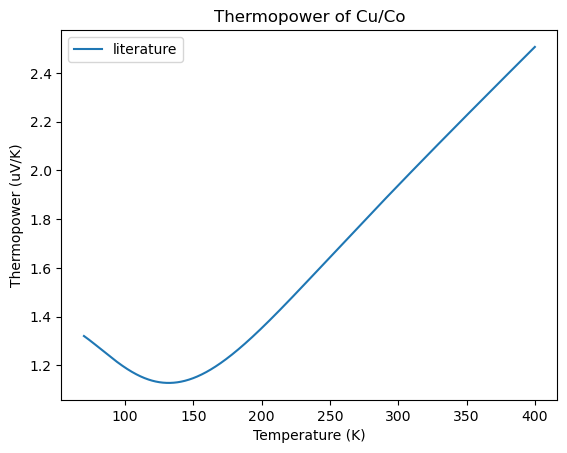

In [511]:
# seebeck coefficient of Cu/Con

# plot the literature values
plt.figure()
T = np.linspace(70, 400, 1000)
S_Cu_Co = 4.37184 + 0.1676*T - 1.84371 * 10**-4 * T**2 + 1.2244 * 10**-7 * T**3 - 4.47618 * 10**-11 * T**4

# plot the data
plt.plot(T, S_Cu, label='literature')
plt.xlabel('Temperature (K)')
plt.ylabel('Thermopower (uV/K)')
plt.title('Thermopower of Cu/Co')
plt.legend()
plt.show()

In [512]:
def read_csv(file_path):
    """
    Read csv file and return a pandas dataframe
    
    Parameters:
    file_path: str, path to the csv file
    
    Returns:
    data: pandas dataframe
    """
    data = pd.read_csv(file_path)
    return data

In [513]:
# calculate the temperature from the resistance of a PT100
def PT100_Temperature(PT100_Resistance):
    A = 3.9083e-3
    B = -5.775e-7
    R0 = 100.0
    T = (-R0 * A + np.sqrt(R0**2 * A**2 - 4 * R0 * B * (R0 - PT100_Resistance))) / (2 * R0 * B)
    return T


def PT100_Resistance(V_in, V_diff, R1, R2):
    num = R1 * (R2/(R1+R2) + V_diff/V_in)
    den = 1 - (R2/(R1+R2) + V_diff/V_in)
    return num/den


In [316]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def smooth_column(data, cutoff, column, order=5):
    """
    Smooth the voltage data using a butterworth filter
    Parameters:
    data: a pandas dataframe with a column which should be smoothed
    cutoff: the cutoff frequency (Hz)
    order: the order of the filter (default 5)

    Returns:
    the smoothed data as a pandas dataframe
    """

    # check if the data has a voltage column
    if column not in data.columns:
        raise ValueError('The data does not have the specified column')
    
    data_smoothed = data.copy()

    fs = 1.0 / (data_smoothed['Time'][10001] - data_smoothed['Time'][10000])

    # name of the column to smooth
    data_smoothed[column + '_lowpass'] = butter_lowpass_filter(data[column], cutoff, fs, order)
    return data_smoothed

# Compute Temperature

In [317]:
Kupfer_Konstantan = read_csv('data_combined/Kupfer_Konstantan_Full_Range.csv')
Kupfer_Nickel = read_csv('data_combined/Kupfer_Nickel_Full_Range.csv')

Kupfer_Konstantan['V_R'] = Kupfer_Konstantan['V_R']/1000
Kupfer_Nickel['V_R'] = Kupfer_Nickel['V_R']/1000

Kupfer_Konstantan['V_T'] = Kupfer_Konstantan['V_T']/1000
Kupfer_Nickel['V_T'] = Kupfer_Nickel['V_T']/1000

Kupfer_Konstantan['Resistance'] = PT100_Resistance(5.017, Kupfer_Konstantan['V_R'], 2200, 100)
Kupfer_Konstantan['Temperature'] = PT100_Temperature(PT100_Resistance(5.017, Kupfer_Konstantan['V_R'], 2200, 100)) + 273.15
Kupfer_Nickel['Resistance'] = PT100_Resistance(5.017, Kupfer_Nickel['V_R'], 2200, 100)
Kupfer_Nickel['Temperature'] = PT100_Temperature(PT100_Resistance(5.017, Kupfer_Nickel['V_R'], 2200, 100)) + 273.15

# remove the first and last 5000 values
drop_first_last = 50
Kupfer_Konstantan = Kupfer_Konstantan[drop_first_last:-drop_first_last]
Kupfer_Nickel = Kupfer_Nickel[drop_first_last:-drop_first_last]

# Filter Temperature and thermostat Voltage

In [318]:
# move a sliding window of 1000 values and remove all temperature values that are more than 5 degrees from the mean temperature in the window
window_size = 1000
window_step = 1000
window_start = 0
window_end = window_size

Kupfer_Konstantan['Temperature_filtered'] = np.nan
Kupfer_Konstantan['V_T_filtered'] = np.nan

while window_end < len(Kupfer_Konstantan):
    mean_temperature = np.mean(Kupfer_Konstantan['Temperature'][window_start:window_end])
    Kupfer_Konstantan['Temperature_filtered'][window_start:window_end] = np.where(abs(Kupfer_Konstantan['Temperature'][window_start:window_end] - mean_temperature) > 5, np.nan, Kupfer_Konstantan['Temperature'][window_start:window_end])

    mean_thermostat_voltage = np.mean(Kupfer_Konstantan['V_T'][window_start:window_end])
    Kupfer_Konstantan['V_T_filtered'][window_start:window_end] = np.where(abs(Kupfer_Konstantan['V_T'][window_start:window_end] - mean_thermostat_voltage) > 0.0002, np.nan, Kupfer_Konstantan['V_T'][window_start:window_end])
    
    window_start += window_step
    window_end += window_step

/var/folders/5q/chddvdnn39g8dvphqtky5wy00000gn/T/ipykernel_44870/835683164.py:12: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Kupfer_Konstantan['Temperature_filtered'][window_start:window_end] = np.where(abs(Kupfer_Konstantan['Temperature'

In [319]:
window_size = 1000
window_step = 1000
window_start = 0
window_end = window_size

Kupfer_Nickel['Temperature_filtered'] = np.nan
Kupfer_Nickel['V_T_filtered'] = np.nan

while window_end < len(Kupfer_Nickel):
    mean_temperature = np.mean(Kupfer_Nickel['Temperature'][window_start:window_end])
    Kupfer_Nickel['Temperature_filtered'][window_start:window_end] = np.where(abs(Kupfer_Nickel['Temperature'][window_start:window_end] - mean_temperature) > 5, np.nan, Kupfer_Nickel['Temperature'][window_start:window_end])

    mean_thermostat_voltage = np.mean(Kupfer_Nickel['V_T'][window_start:window_end])
    Kupfer_Nickel['V_T_filtered'][window_start:window_end] = np.where(abs(Kupfer_Nickel['V_T'][window_start:window_end] - mean_thermostat_voltage) > 0.0002, np.nan, Kupfer_Nickel['V_T'][window_start:window_end])

    window_start += window_step
    window_end += window_step

/var/folders/5q/chddvdnn39g8dvphqtky5wy00000gn/T/ipykernel_44870/2831309495.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  Kupfer_Nickel['Temperature_filtered'][window_start:window_end] = np.where(abs(Kupfer_Nickel['Temperature'][windo

In [320]:
#replace nan values with the closest non-nan value
Kupfer_Konstantan['Temperature_filtered'] = Kupfer_Konstantan['Temperature_filtered'].interpolate(method='nearest')
Kupfer_Nickel['Temperature_filtered'] = Kupfer_Nickel['Temperature_filtered'].interpolate(method='nearest')

Kupfer_Konstantan['V_T_filtered'] = Kupfer_Konstantan['V_T_filtered'].interpolate(method='nearest')
Kupfer_Nickel['V_T_filtered'] = Kupfer_Nickel['V_T_filtered'].interpolate(method='nearest')

In [321]:
# drop the first and last 50 values
drop_first_last = 5000
Kupfer_Konstantan = Kupfer_Konstantan[drop_first_last:-drop_first_last]
Kupfer_Nickel = Kupfer_Nickel[drop_first_last:-drop_first_last]

In [454]:
import numpy as np

def monte_carlo_polyfit_with_x_err(x, y, x_err, degree, n_simulations=1000):
    """
    Perform a Monte Carlo simulation to estimate the uncertainty in polynomial coefficients
    due to uncertainties in x values.
    
    Parameters:
    - x: array-like, independent variable data.
    - y: array-like, dependent variable data.
    - x_err: array-like or float, standard deviation of uncertainty in x values.
    - degree: int, degree of the polynomial fit.
    - n_simulations: int, number of Monte Carlo simulations to perform.
    
    Returns:
    - coefficients_dist: array, distribution of polynomial coefficients from the simulations.
    """
    
    coefficients_dist = np.zeros((n_simulations, degree + 1))
    
    for i in range(n_simulations):
        # Add normally distributed errors to x values based on x_err
        if np.isscalar(x_err):
            x_simulated = x + np.random.normal(0, x_err, size=x.shape)
        else:
            # If x_err is an array, apply element-wise
            x_simulated = x + np.random.normal(0, x_err)
        
        # Fit polynomial to the simulated dataset
        coefficients_dist[i] = np.polyfit(x_simulated, y, degree)
    
    return coefficients_dist


In [456]:
# find a polynomial fit for the data for a range of degrees
# enforce that the polynomial has a zero at 273.15 K

uncertainty_temperature_k_k = 0.3 + (np.abs(Kupfer_Konstantan['Temperature_filtered'] - 273.15)) * 0.005
uncertainty_temperature_k_n = 0.3 + (np.abs(Kupfer_Nickel['Temperature_filtered'] - 273.15)) * 0.005

polynomial_k_k, cov_k_k = np.polyfit(Kupfer_Konstantan['Temperature_filtered'], Kupfer_Konstantan['V_T_filtered'], 4, cov=True)
polynomial_k_n, cov_k_n = np.polyfit(Kupfer_Nickel['Temperature_filtered'], Kupfer_Nickel['V_T_filtered'], 4, cov=True)

error_k_k = Kupfer_Konstantan['V_T_filtered'] - np.polyval(polynomial_k_k, Kupfer_Konstantan['Temperature_filtered'])
error_k_n = Kupfer_Nickel['V_T_filtered'] - np.polyval(polynomial_k_n, Kupfer_Nickel['Temperature_filtered'])

In [457]:
coefficients_dist_k_k = monte_carlo_polyfit_with_x_err(Kupfer_Konstantan['Temperature_filtered'], Kupfer_Konstantan['V_T_filtered'], uncertainty_temperature_k_k, 4)
coefficients_dist_k_n = monte_carlo_polyfit_with_x_err(Kupfer_Nickel['Temperature_filtered'], Kupfer_Nickel['V_T_filtered'], uncertainty_temperature_k_n, 4)

In [476]:
# calculate the mean and standard deviation of the coefficients
mean_coefficients_k_k = np.mean(coefficients_dist_k_k, axis=0)
std_coefficients_k_k = np.std(coefficients_dist_k_k, axis=0)
upper_poly_fit_k_k = np.polyval(mean_coefficients_k_k + 1.96 * std_coefficients_k_k, Kupfer_Konstantan['Temperature_filtered'])
lower_poly_fit_k_k = np.polyval(mean_coefficients_k_k - 1.96 * std_coefficients_k_k, Kupfer_Konstantan['Temperature_filtered'])

mean_coefficients_k_n = np.mean(coefficients_dist_k_n, axis=0)
std_coefficients_k_n = np.std(coefficients_dist_k_n, axis=0)
upper_poly_fit_k_n = np.polyval(mean_coefficients_k_n + 1.96 * std_coefficients_k_n, Kupfer_Nickel['Temperature_filtered'])
lower_poly_fit_k_n = np.polyval(mean_coefficients_k_n - 1.96 * std_coefficients_k_n, Kupfer_Nickel['Temperature_filtered'])

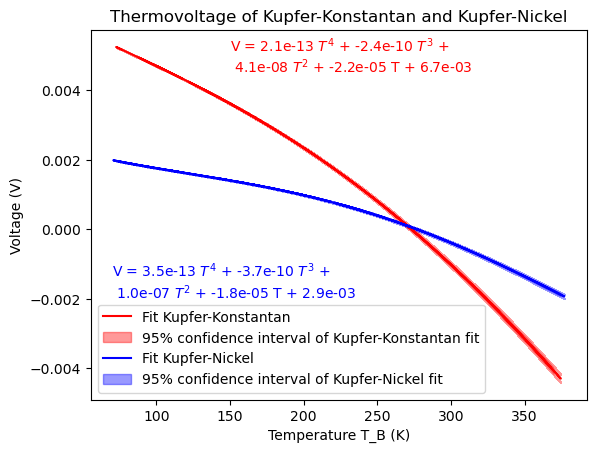

In [542]:
# plot the data
plt.figure()
#plt.plot(Kupfer_Konstantan['Temperature_filtered'], Kupfer_Konstantan['V_T_filtered'], label='Kupfer-Konstantan')
#plt.plot(Kupfer_Nickel['Temperature_filtered'], Kupfer_Nickel['V_T_filtered'], label='Kupfer-Nickel')
plt.plot(Kupfer_Konstantan['Temperature_filtered'], np.polyval(polynomial_k_k, Kupfer_Konstantan['Temperature_filtered']), label='Fit Kupfer-Konstantan', color='red')
# write the polynomial coefficients
plt.text(150, 0.0045, 'V = {:.1e} $T^4$ + {:.1e} $T^3$ + \n {:.1e} $T^2$ + {:.1e} T + {:.1e}'.format(*mean_coefficients_k_k), color='red')
# shade the area between the upper and lower fit
plt.fill_between(Kupfer_Konstantan['Temperature_filtered'], upper_poly_fit_k_k, lower_poly_fit_k_k, color='red', alpha=0.4, label='95% confidence interval of Kupfer-Konstantan fit')

plt.plot(Kupfer_Nickel['Temperature_filtered'], np.polyval(polynomial_k_n, Kupfer_Nickel['Temperature_filtered']), label='Fit Kupfer-Nickel', color='blue')
plt.text(70, -0.002, 'V = {:.1e} $T^4$ + {:.1e} $T^3$ + \n {:.1e} $T^2$ + {:.1e} T + {:.1e}'.format(*mean_coefficients_k_n), color='blue')
# shade the area between the upper and lower fit
plt.fill_between(Kupfer_Nickel['Temperature_filtered'], upper_poly_fit_k_n, lower_poly_fit_k_n, color='blue', alpha=0.4, label='95% confidence interval of Kupfer-Nickel fit')
plt.xlabel('Temperature T_B (K)')
plt.ylabel('Voltage (V)')
plt.title('Thermovoltage of Kupfer-Konstantan and Kupfer-Nickel')
plt.legend()

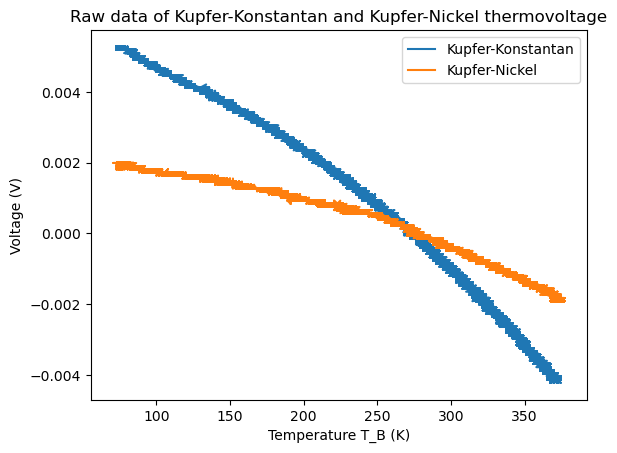

In [497]:
# plot temperature vs voltage
plt.figure()
plt.plot(Kupfer_Konstantan['Temperature_filtered'], Kupfer_Konstantan['V_T_filtered'], label='Kupfer-Konstantan')
plt.plot(Kupfer_Nickel['Temperature_filtered'], Kupfer_Nickel['V_T_filtered'], label='Kupfer-Nickel')

# mark the zero crossing of the polynomial fit
zero_crossing_k_k = np.roots(polynomial_k_k)
zero_crossing_k_n = np.roots(polynomial_k_n)

plt.xlabel('Temperature T_B (K)')
plt.ylabel('Voltage (V)')
plt.title('Raw data of Kupfer-Konstantan and Kupfer-Nickel thermovoltage')
plt.legend()
plt.show()

In [427]:
#print error_k_k at 273.15 K
print('Error in the fit of Kupfer-Konstantan at 273.15 K: ', np.polyval(polynomial_k_k, 273.15), 'V')

Error in the fit of Kupfer-Konstantan at 273.15 K:  1.7817562084163768e-06 V


In [415]:
print('Zero crossing of Kupfer-Konstantan:', zero_crossing_k_k)
print('Zero crossing of Kupfer-Nickel:', zero_crossing_k_n)

Zero crossing of Kupfer-Konstantan: [1020.74590771  +0.j          -79.3824293 +331.07012485j
  -79.3824293 -331.07012485j  273.1989936   +0.j        ]
Zero crossing of Kupfer-Nickel: [712.8219648   +0.j         276.92167504  +0.j
  26.02026502+201.77386208j  26.02026502-201.77386208j]


# uncertainty calculations from fitting

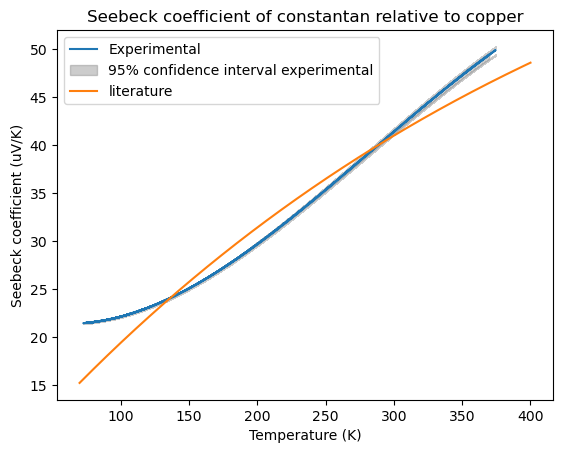

In [531]:
plt.figure()

# the derivative of the polynomial fit
dp = np.polyder(polynomial_k_k)
dp_upper = np.polyder(mean_coefficients_k_k + 1.96 * std_coefficients_k_n)
dp_lower = np.polyder(mean_coefficients_k_k - 1.96 * std_coefficients_k_n)


dVdT = np.polyval(dp, Kupfer_Konstantan['Temperature_filtered']) * 10 ** 6
dVdT_upper = np.polyval(dp_upper, Kupfer_Konstantan['Temperature_filtered']) * 10 ** 6
dVdT_lower = np.polyval(dp_lower, Kupfer_Konstantan['Temperature_filtered']) * 10 ** 6

S_Ni_0 = 12

T = 273.15
S_Cu_0 = 0.041 * T * (np.exp(-T/93) + 0.123 - (0.442)/(1 + (T / 172.4)**3)) + 0.804
S_Cu_Co_0 = 4.37184 + 0.1676*T - 1.84371 * 10**-4 * T**2 + 1.2244 * 10**-7 * T**3 - 4.47618 * 10**-11 * T**4
S_Co_0 = S_Cu_0 - S_Cu_Co_0

# plot the derivative of the polynomial fit
#the line color should be shades of gray
# the line color should get darker as the degree of the polynomial increases
plt.plot(Kupfer_Konstantan['Temperature_filtered'] , -(dVdT - S_Cu_0), label='Experimental')
# plot area between the upper and lower derivative
plt.fill_between(Kupfer_Konstantan['Temperature_filtered'], -(dVdT_upper - S_Cu_0), -(dVdT_lower - S_Cu_0), color='gray', alpha=0.4, label='95% confidence interval experimental')

# plot the literature values
T = np.linspace(70, 400, 1000)

plt.plot(T, S_Cu_Co, label='literature')

plt.xlabel('Temperature (K)')
plt.ylabel('Seebeck coefficient (uV/K)')
plt.title('Seebeck coefficient of constantan relative to copper')
plt.legend()
plt.show()

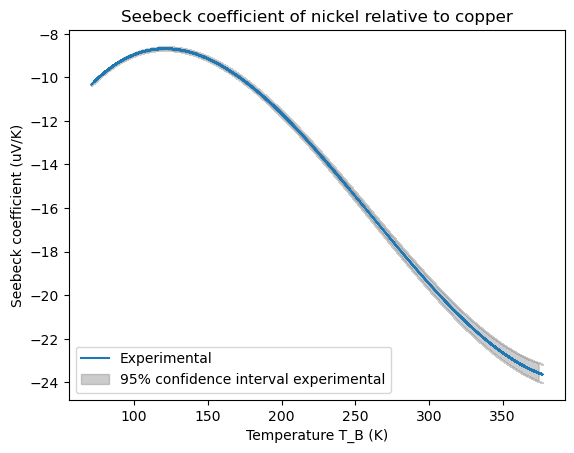

In [535]:
plt.figure()

# the derivative of the polynomial fit
dp = np.polyder(polynomial_k_n)
dp_upper = np.polyder(mean_coefficients_k_n + 1.96 * std_coefficients_k_n)
dp_lower = np.polyder(mean_coefficients_k_n - 1.96 * std_coefficients_k_n)

dVdT =  np.polyval(dp, Kupfer_Nickel['Temperature_filtered']) * 10 ** 6
dVdT_upper = np.polyval(dp_upper, Kupfer_Nickel['Temperature_filtered']) * 10 ** 6
dVdT_lower = np.polyval(dp_lower, Kupfer_Nickel['Temperature_filtered']) * 10 ** 6

# plot the derivative of the polynomial fit
#the line color should be shades of gray
# the line color should get darker as the degree of the polynomial increases
plt.plot(Kupfer_Nickel['Temperature_filtered'], dVdT - S_Cu_0, label='Experimental')
# plot area between the upper and lower derivative
plt.fill_between(Kupfer_Nickel['Temperature_filtered'], dVdT_upper - S_Cu_0, dVdT_lower - S_Cu_0, color='gray', alpha=0.4, label='95% confidence interval experimental')

plt.xlabel('Temperature T_B (K)')
plt.ylabel('Seebeck coefficient (uV/K)')
plt.title('Seebeck coefficient of nickel relative to copper')
plt.legend()
plt.show()